# Explore here

In [3]:
# Your code here
# Your code here
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from pickle import dump

Paso 1: Carga del conjunto de datos
El conjunto de datos se puede encontrar en esta carpeta de proyecto bajo el nombre url_spam.csv. Puedes cargarlo en el código directamente desde el siguiente enlace:

In [4]:
#get the data

url_spam = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')
url_spam.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


Paso 2: Preprocesa los enlaces
Utiliza lo visto en este módulo para transformar los datos para compatibilizarlos con el modelo que queremos entrenar. Segmenta las URLs en partes según sus signos de puntuación, elimina las stopwords, lematiza, etcétera.

Asegúrate de dividir convenientemente el conjunto de datos en train y test como hemos visto en lecciones anteriores

In [5]:
#transform categorical columns to numeric

url_spam['is_spam'] = url_spam['is_spam'].astype(int)
url_spam.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


is_spam = { 'True': 1, 'False': 0 }

In [6]:
print(url_spam.shape)
print(f"Spam: {len(url_spam.loc[url_spam.is_spam == 1])}")
print(f"No spam: {len(url_spam.loc[url_spam.is_spam == 0])}")

(2999, 2)
Spam: 696
No spam: 2303


In [7]:
#chech for duplicated
url_spam.duplicated().shape

(2999,)

In [ ]:
#Delete duplicated
url_spam = url_spam.drop_duplicates()
url_spam.shape

In [8]:
print(url_spam.shape)
print(f"Spam without duplicates: {len(url_spam.loc[url_spam.is_spam == 1])}")
print(f"No spam without duplicates: {len(url_spam.loc[url_spam.is_spam == 0])}")

(2999, 2)
Spam without duplicates: 696
No spam without duplicates: 2303


In [9]:
def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

url_spam["url"] = url_spam["url"].apply(preprocess_text)
url_spam

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1
...,...,...
2994,"[https, www, smartcitiesworld, net, news, news...",0
2995,"[https, www, youtube, com, watch]",1
2996,"[https, techcrunch, com, an, optimistic, view,...",0
2997,"[https, www, technologyreview, com, this, star...",0


In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


#lemmatize and stop words
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))  # Define stop words for English language

def lematize_and_stopwords(words_list):
    lematizadas = [lemmatizer.lemmatize(word.lower(), pos='v') for word in words_list if word.lower() not in stop_words]
    return lematizadas

url_spam['url'] = url_spam['url'].apply(lematize_and_stopwords)
url_spam

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v]",1
3,"[https, briefingday, com, commentform]",0
4,"[https, briefingday, com, fan]",1
...,...,...
2994,"[https, www, smartcitiesworld, net, news, news...",0
2995,"[https, www, youtube, com, watch]",1
2996,"[https, techcrunch, com, optimistic, view, dee...",0
2997,"[https, www, technologyreview, com, startup, c...",0


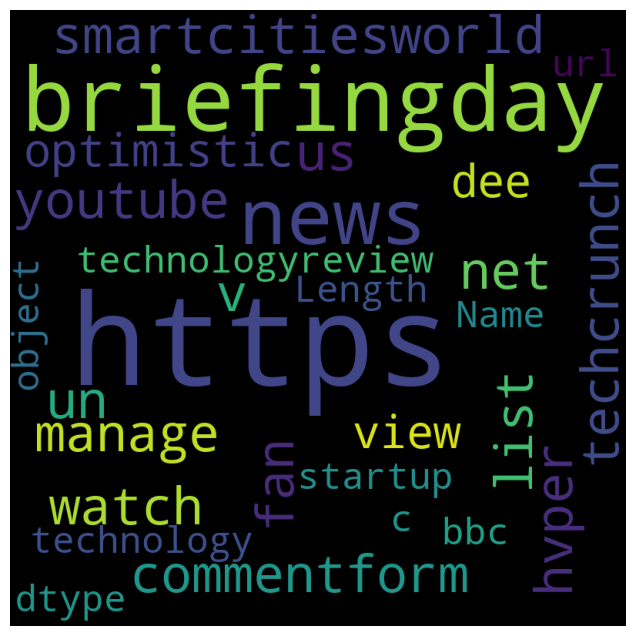

In [15]:
#plot the word cloud
wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 28)\
    .generate(str(url_spam["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [16]:
#vectorize the url column

tokens_ = url_spam["url"]
tokens_ = [" ".join(tokens) for tokens in tokens_]

#set the vectorizer
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(tokens_).toarray()
y = url_spam['is_spam']
print(f'X preview:\n {X}')
print(f'y preview:\n {y}')

X preview:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
y preview:
 0       1
1       1
2       1
3       0
4       1
       ..
2994    0
2995    1
2996    0
2997    0
2998    0
Name: is_spam, Length: 2999, dtype: int64


In [17]:
#split into train and test and build the model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 28)

model_svm = SVC(kernel = "linear", random_state = 28)
model_svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=28)

In [18]:
#check the accuracy
y_pred = model_svm.predict(X_test)
model_accuracy = accuracy_score(y_test, y_pred)
print(f'Model accuracy: {model_accuracy}')

Model accuracy: 0.9516666666666667


In [19]:
#save the model

dump(model_svm, open("../models/svm_classifier_linear_28.sav", "wb"))